In [1]:
!pip install fastai
!pip install kagglehub

# Download images

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

100%|██████████| 1.03G/1.03G [00:47<00:00, 23.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1


In [6]:
import os

os.listdir(path + '/asl_alphabet_train/asl_alphabet_train')

['S',
 'F',
 'V',
 'space',
 'K',
 'W',
 'B',
 'L',
 'P',
 'U',
 'M',
 'J',
 'C',
 'I',
 'G',
 'X',
 'E',
 'T',
 'Z',
 'D',
 'O',
 'Y',
 'Q',
 'R',
 'H',
 'nothing',
 'del',
 'A',
 'N']

# Load Data

In [7]:
from fastai.vision.all import *

In [8]:
letters = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

# Add extra paths to path.
dls = letters.dataloaders(path + '/asl_alphabet_train/asl_alphabet_train')

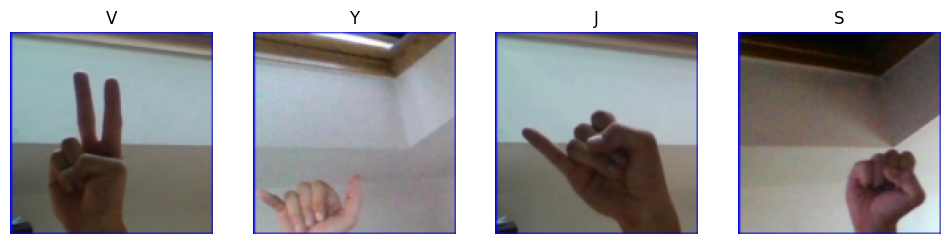

In [9]:
dls.valid.show_batch(max_n=4, nrows=1)

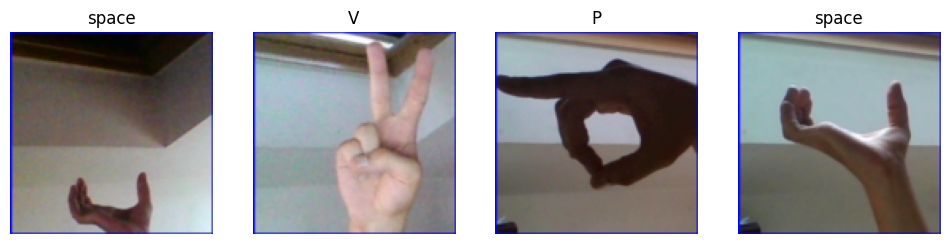

In [11]:
letters = letters.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = letters.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)
# No effect bc all images have the same shape

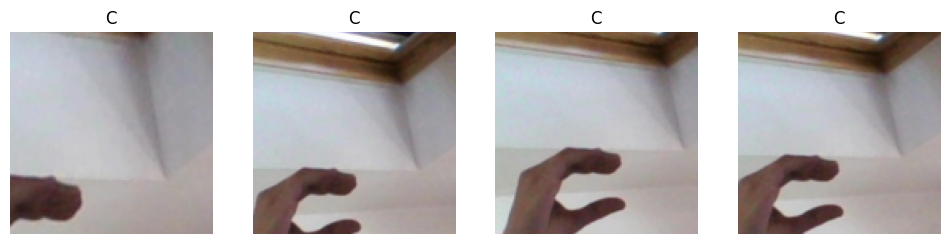

In [12]:
letters = letters.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = letters.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)
# Does this make sense for ASL recognition? I'd say not really...
# because if you don't have the full sign you can't figure out. So really you need
# an extra class with not enough info?
# Or would it be better because you get a probability anyway? Unsure.

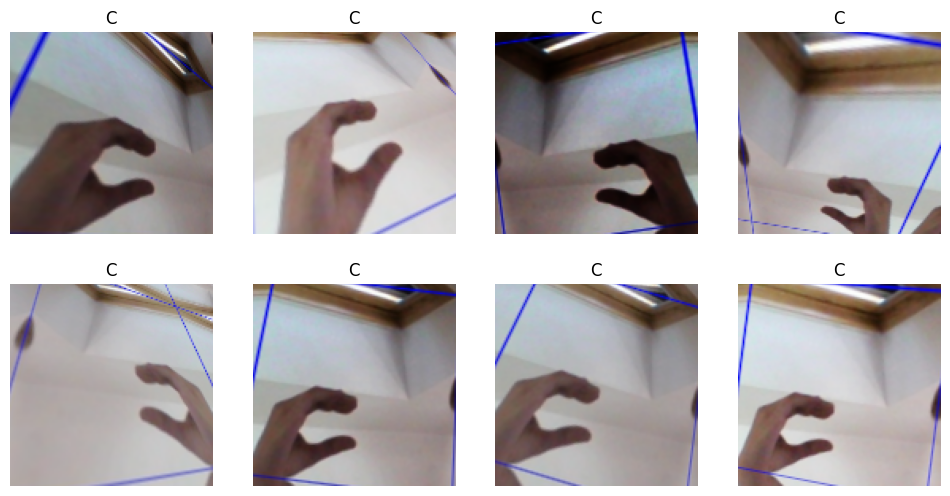

In [13]:
letters = letters.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = letters.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Train model

In [16]:
# To test with and without random resized crop :)
letters = letters.new(
    item_tfms=None,
    batch_tfms=aug_transforms())
dls = letters.dataloaders(path + '/asl_alphabet_train/asl_alphabet_train')

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)
# Need a GPU for this - try on GColab - works!

epoch,train_loss,valid_loss,error_rate,time
0,0.247283,0.083839,0.027989,03:53


epoch,train_loss,valid_loss,error_rate,time
0,0.040805,0.022690,0.006494,04:42
1,0.021729,0.003039,0.000920,04:38
2,0.004561,0.000693,0.000172,04:40
3,0.001310,0.000065,0.000000,04:40


In [23]:
learn.save('asl_base_model')

Path('models/asl_base_model.pth')

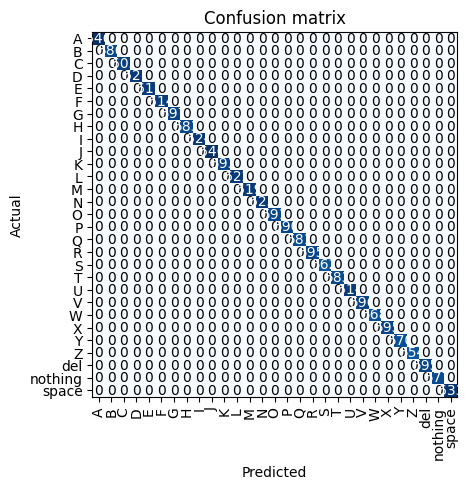

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

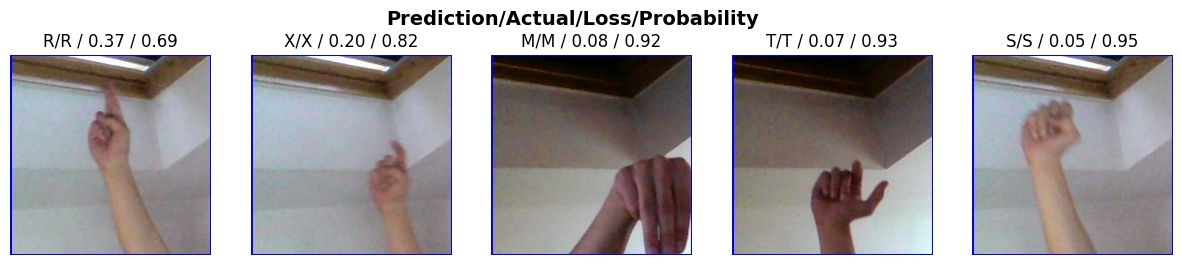

In [19]:
interp.plot_top_losses(5, nrows=1)

In [21]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)